In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
from zipfile import ZipFile
file_name = '/content/drive/MyDrive/data.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [6]:
from cProfile import label
import cv2
import os
from PIL import Image
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
import numpy as np
import time
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Conv2D, ELU, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, KFold, cross_validate

In [7]:
%matplotlib inline

In [8]:
cascade_face = cv2.CascadeClassifier('haarcascade_frontalface_alt.xml')
cascade_smile = cv2.CascadeClassifier('haarcascade_smile.xml')
cascade_mouth = cv2.CascadeClassifier('haarcascade_mcs_mouth.xml')

In [9]:
def crop_faces(source_dir, output_dir):
    """
    Retrieves the images from the given directory and locates the face within each image and crops it
    as a rectangle. The function assumes there is only one face
    """
    failed_to_crop = []
    for index, image_file in enumerate(sorted(os.listdir(source_dir))):

        image_path = os.path.join(source_dir, image_file)
        if ".DS_Store" in image_path:
            continue
            
        image = Image.open(image_path).convert('LA')
        # Haar Cascade detectMultiScale function takes image, ScaleFactor, minNeighbors
        SCALE_FACTOR = 1.1
        MIN_NEIGHBORS = 5
        # cv2_image = cascade_smile.detectMultiScale(cv2.imread(image_path),  1.1, 12)
        cv2_image = cascade_face.detectMultiScale(cv2.imread(image_path), SCALE_FACTOR, MIN_NEIGHBORS)
        
        cropped_filename = 'cropped_' + image_file[:-4] + '.png'
        write_path = os.path.join(output_dir, cropped_filename)
        if len(cv2_image) != 0:
            # face detected
            # cv2_image.save(write_path)
            for face in cv2_image:
                cropped_image = crop_image(image, cv2_image[0])
                cropped_image.save(write_path)
        else:
            # save the original image
            failed_to_crop.append(index)
            image.save(write_path)

def crop_image(image, feature):
    """
    Crop the image based on the detected frame of the feature
    """
    # cropping area: x, y, x + w, y + h
    area = (feature[0], feature[1], feature[0] + feature[2], feature[1] + feature[3])
    return image.crop(area)

In [10]:
def process_data(src_dir, labels_path, img_size, grey_scale=False):
    # get list of image files
    image_files = sorted(os.listdir(src_dir))

    # allocate space for images and their respective labels
    if grey_scale:
      image_data = np.ndarray(shape=(len(image_files), img_size, img_size, 1), dtype=np.float32)
    else:
      image_data = np.ndarray(shape=(len(image_files), img_size, img_size, 3), dtype=np.float32)
    labels = np.zeros(len(image_files))

    # image data 
    for i, image in enumerate(image_files):
        if image[-3:] == 'png':
            # read image
            curr_image = cv2.imread(os.path.join(src_dir, image)).astype('float32')
            if grey_scale:
              grey_image = cv2.cvtColor(curr_image, cv2.COLOR_BGR2GRAY)
              image_data[i, :, :, :] = cv2.resize(grey_image, (img_size, img_size)).reshape((img_size, img_size, 1))
            else:
              image_data[i, :, :, :] = cv2.resize(curr_image, (img_size, img_size))

    # label data
    label_file = open(labels_path, "r")
    for i, label in enumerate(label_file):
        labels[i] = label.split()[0]
    label_file.close()

    failed_to_crop = [15, 18, 30, 39, 64, 81, 82, 86, 114, 125, 182, 207, 208, 216, 217, 241, 261, 264, 281, 295, 319, 330, 334, 352, 353, 354, 398, 399, 404, 410, 434, 437, 444, 453, 454, 466, 506, 540, 544, 549, 553, 587, 669, 672, 674, 675, 688, 694, 701, 703, 707, 710, 739, 752, 777, 782, 786, 822, 825, 829, 858, 873, 880, 881, 930, 941, 995, 1018, 1038, 1067, 1068, 1082, 1086, 1096, 1100, 1120, 1136, 1179, 1247, 1270, 1272, 1292, 1303, 1312, 1318, 1351, 1355, 1367, 1402, 1403, 1429, 1474, 1497, 1499, 1500, 1506, 1508, 1515, 1543, 1562, 1568, 1569, 1574, 1580, 1582, 1591, 1613, 1621, 1645, 1646, 1654, 1666, 1684, 1690, 1726, 1749, 1759, 1760, 1761, 1765, 1767, 1776, 1777, 1797, 1808, 1812, 1819, 1861, 1872, 1879, 1887, 1899, 1923, 1937, 1945, 1947, 1958, 1970, 1978, 1992, 2006, 2024, 2046, 2064, 2081, 2110, 2111, 2131, 2147, 2169, 2177, 2190, 2195, 2199, 2205, 2210, 2211, 2233, 2261, 2267, 2268, 2307, 2314, 2322, 2326, 2329, 2343, 2344, 2361, 2386, 2394, 2398, 2421, 2423, 2461, 2471, 2472, 2485, 2490, 2502, 2508, 2510, 2515, 2530, 2543, 2585, 2599, 2602, 2609, 2640, 2651, 2660, 2671, 2705, 2743, 2752, 2761, 2771, 2773, 2805, 2807, 2821, 2826, 2830, 2838, 2841, 2845, 2863, 2870, 2871, 2892, 2893, 2927, 2974, 2989, 2993, 3019, 3026, 3091, 3148, 3160, 3164, 3170, 3198, 3212, 3214, 3271, 3275, 3321, 3348, 3393, 3401, 3410, 3411, 3415, 3416, 3430, 3471, 3480, 3481, 3508, 3511, 3522, 3527, 3553, 3554, 3558, 3567, 3569, 3580, 3586, 3587, 3629, 3643, 3646, 3654, 3662, 3664, 3666, 3671, 3676, 3677, 3679, 3702, 3705, 3792, 3793, 3808, 3811, 3815, 3816, 3817, 3837, 3851, 3861, 3884, 3890, 3899, 3900, 3902, 3921, 3932, 3946, 3949, 3950, 3971, 3973, 3978, 3987, 3989]

    image_data = np.delete(image_data, failed_to_crop, axis=0)
    labels = np.delete(labels, failed_to_crop)

    print(image_data.shape)
    print(labels.shape)

    return image_data, labels

In [11]:
def flatten_data(src_dir, labels_path, width, height):
    image_files = sorted(os.listdir(src_dir))
    labels = np.zeros(len(image_files))
    images = []

    standard_size = (100, 100)

    for i, image_path in enumerate(image_files):
         if image_path[-3:] == 'png':
            # read image
            curr_image = cv2.imread(os.path.join(src_dir, image_path)).astype('float32')
            gray_image = cv2.cvtColor(curr_image, cv2.COLOR_BGR2GRAY)
            resized = cv2.resize(gray_image, (width, height))
            images.append(resized)


    label_file = open(labels_path, "r")
    for i, label in enumerate(label_file):
        labels[i] = label.split()[0]
    label_file.close()

    failed_to_crop = [15, 18, 30, 39, 64, 81, 82, 86, 114, 125, 182, 207, 208, 216, 217, 241, 261, 264, 281, 295, 319, 330, 334, 352, 353, 354, 398, 399, 404, 410, 434, 437, 444, 453, 454, 466, 506, 540, 544, 549, 553, 587, 669, 672, 674, 675, 688, 694, 701, 703, 707, 710, 739, 752, 777, 782, 786, 822, 825, 829, 858, 873, 880, 881, 930, 941, 995, 1018, 1038, 1067, 1068, 1082, 1086, 1096, 1100, 1120, 1136, 1179, 1247, 1270, 1272, 1292, 1303, 1312, 1318, 1351, 1355, 1367, 1402, 1403, 1429, 1474, 1497, 1499, 1500, 1506, 1508, 1515, 1543, 1562, 1568, 1569, 1574, 1580, 1582, 1591, 1613, 1621, 1645, 1646, 1654, 1666, 1684, 1690, 1726, 1749, 1759, 1760, 1761, 1765, 1767, 1776, 1777, 1797, 1808, 1812, 1819, 1861, 1872, 1879, 1887, 1899, 1923, 1937, 1945, 1947, 1958, 1970, 1978, 1992, 2006, 2024, 2046, 2064, 2081, 2110, 2111, 2131, 2147, 2169, 2177, 2190, 2195, 2199, 2205, 2210, 2211, 2233, 2261, 2267, 2268, 2307, 2314, 2322, 2326, 2329, 2343, 2344, 2361, 2386, 2394, 2398, 2421, 2423, 2461, 2471, 2472, 2485, 2490, 2502, 2508, 2510, 2515, 2530, 2543, 2585, 2599, 2602, 2609, 2640, 2651, 2660, 2671, 2705, 2743, 2752, 2761, 2771, 2773, 2805, 2807, 2821, 2826, 2830, 2838, 2841, 2845, 2863, 2870, 2871, 2892, 2893, 2927, 2974, 2989, 2993, 3019, 3026, 3091, 3148, 3160, 3164, 3170, 3198, 3212, 3214, 3271, 3275, 3321, 3348, 3393, 3401, 3410, 3411, 3415, 3416, 3430, 3471, 3480, 3481, 3508, 3511, 3522, 3527, 3553, 3554, 3558, 3567, 3569, 3580, 3586, 3587, 3629, 3643, 3646, 3654, 3662, 3664, 3666, 3671, 3676, 3677, 3679, 3702, 3705, 3792, 3793, 3808, 3811, 3815, 3816, 3817, 3837, 3851, 3861, 3884, 3890, 3899, 3900, 3902, 3921, 3932, 3946, 3949, 3950, 3971, 3973, 3978, 3987, 3989]
    images = np.array(images)
    print(images.shape)
    images = np.delete(images, failed_to_crop, axis=0)
    labels = np.delete(labels, failed_to_crop)
    print(images.shape)

    num_images, width, height = images.shape

    images_flat = images.reshape((num_images, height*width))

    return images_flat, labels

In [12]:
def perform_PCA(x_train):
    pca_dims = PCA()
    pca_dims.fit(x_train)
    cumsum = np.cumsum(pca_dims.explained_variance_ratio_)
    d = np.argmax(cumsum >= 0.95) + 1
    pca = PCA(n_components=d)
    return pca

In [13]:
def k_fold_cross_val(model, x, y, n_splits):
    cv = KFold(n_splits=n_splits, shuffle=True)
    scoring = {
        'acc': 'accuracy',
        'prec': 'precision',
        'rec': 'recall',
        'f1': 'f1',
        'auc': 'roc_auc',
    }
    scores = cross_validate(model, x, y, scoring=scoring, cv=cv, n_jobs=-1)
    mean_acc_test = scores['test_acc'].mean()
    mean_prec_test = scores['test_prec'].mean()
    mean_rec_test = scores['test_rec'].mean()
    mean_f1_test = scores['test_f1'].mean()
    mean_auc_test = scores['test_auc'].mean()
    return mean_acc_test, mean_prec_test, mean_rec_test, mean_f1_test, mean_auc_test

In [14]:
def train_test_split(data, labels):
    """
    Split the data into training and testing data. 3/4 of the data for training and 1/4 for testing.
    Shuffle the data so its randomized.
    """

    shuffled_indices = [i for i in range(len(data))]
    # print(shuffled_indices)
    np.random.shuffle(shuffled_indices)

    data = data[shuffled_indices]
    labels = labels[shuffled_indices]

    split = int(len(data) * 3/4)
    x_train, x_test = data[:split], data[split:]
    y_train, y_test = labels[:split], labels[split:]

    return x_train, y_train, x_test, y_test

In [15]:
def perform_gridsearch(model, parameters, x_train, y_train):
  gridsearch = GridSearchCV(model, parameters)
  gridsearch.fit(x_train, y_train)
  return gridsearch.best_params_

In [16]:
def score_report(classes, y_train_pred, y_train, y_test_pred, y_test):
    print("----------- Training Set Report -----------")
    print("Accuracy", accuracy_score(y_train, y_train_pred))
    print("Precision", precision_score(y_train, y_train_pred))
    print("Recall", recall_score(y_train, y_train_pred))
    print("F1", f1_score(y_train, y_train_pred))
    print("AUC", roc_auc_score(y_train, y_train_pred))
    cm = confusion_matrix(y_train, y_train_pred, labels=classes)
    print("Confusion matrix", cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot()
    plt.show()
    print("----------- Testing Set Report -----------")
    print("Accuracy", accuracy_score(y_test, y_test_pred))
    print("Precision", precision_score(y_test, y_test_pred))
    print("Recall", recall_score(y_test, y_test_pred))
    print("F1", f1_score(y_test, y_test_pred))
    print("AUC", roc_auc_score(y_test, y_test_pred))
    cm = confusion_matrix(y_test, y_test_pred, labels=classes)
    print("Confusion matrix", cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot()
    plt.show()

In [17]:
def generate_roc(model, x_test, y_test):
  ax = plt.gca()
  RocCurveDisplay.from_estimator(model, x_test, y_test, ax=ax, alpha=.8)
  plt.title("ROC")
  plt.show()

In [18]:
def build_CNN_basic():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='sigmoid'))
    print(model.summary())
    return model

In [19]:
def build_CNN_LeNet():
    model = Sequential()
    model.add(Conv2D(20, (5, 5), padding='same', strides=(1, 1), input_shape=(32, 32, 1)))
    model.add(ELU())
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Dropout(0.4))
    model.add(Conv2D(50, (5, 5), padding='same', strides=(1, 1)))
    model.add(ELU())
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(500))
    model.add(ELU())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    print(model.summary())
    return model

In [20]:
def build_CNN_AlexNet():
    model = Sequential()
    model.add(Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=(227, 227, 3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((3, 3), strides=(2, 2)))
    model.add(Conv2D(256, (5, 5), strides=(1, 1), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((3, 3), strides=(2, 2)))
    model.add(Conv2D(384, (5, 5), strides=(1, 1), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((3, 3), strides=(2, 2)))
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    print(model.summary())
    return model

In [21]:
def predict_label(y_pred):
  return np.array([1 if predicted[0] > 0.5 else 0 for predicted in y_pred])

In [19]:
original_source_dir = '/content/data/genki4k/files/original'
cropped_dir = '/content/data/genki4k/files/cropped_faces1'
labels_dir = '/content/data/genki4k/labels.txt'

# Run this once
# crop_faces(original_source_dir, cropped_dir)

RANDOM FOREST CLASSIFIER

In [22]:
print("Starting timer")
start = time.perf_counter()
original_source_dir = '/content/data/genki4k/files/original'
cropped_dir = '/content/data/genki4k/files/cropped_faces1'
labels_dir = '/content/data/genki4k/labels.txt'

IMAGE_RESCALE_SIZE = 100

face_data, labels = flatten_data(cropped_dir, labels_dir, IMAGE_RESCALE_SIZE, IMAGE_RESCALE_SIZE)
print(f"Processed data ran in {time.perf_counter() - start:0.4f} seconds")

# # train-test split
x_train, y_train, x_test, y_test = train_test_split(face_data, labels)
print(f"Train test split ran in {time.perf_counter() - start:0.4f} seconds")

# rfc_parameters = {
#     'n_estimators': [50, 100, 200, 500],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'criterion': ['gini', 'entropy'],
# }
# rfc_best_params = perform_gridsearch(RandomForestClassifier(), rfc_parameters, x_train, y_train)
# print(f"RFC grid search cross validation ran in {time.perf_counter() - start:0.4f} seconds")
# print(rfc_best_params)

Starting timer
(4000, 100, 100)
(3710, 100, 100)
Processed data ran in 2.7583 seconds
Train test split ran in 2.7940 seconds


In [23]:
# K - fold cross validation
rfc = RandomForestClassifier(criterion='entropy', max_features='auto', n_estimators=200)
mean_acc_test, mean_prec_test, mean_rec_test, mean_f1_test, mean_auc_test = k_fold_cross_val(rfc, face_data, labels, 10)
print('--------- Random Forest Classifier ----------')
print("Mean test accuracy:", mean_acc_test)
print("Mean test precision:", mean_prec_test)
print("Mean test recall:", mean_rec_test)
print("Mean test f1:", mean_f1_test)
print("Mean test AUC:", mean_auc_test)
print('\n')

--------- Random Forest Classifier ----------
Mean test accuracy: 0.8153638814016173
Mean test precision: 0.8274435380949839
Mean test recall: 0.8338638324869875
Mean test f1: 0.8303647203450637
Mean test AUC: 0.9013152300803441




Starting timer
N-estimators: 1 completed at 0.3793 seconds
N-estimators: 2 completed at 1.0526 seconds
N-estimators: 4 completed at 1.9255 seconds
N-estimators: 8 completed at 3.5025 seconds
N-estimators: 16 completed at 6.2808 seconds
N-estimators: 32 completed at 11.4690 seconds
N-estimators: 64 completed at 21.3830 seconds
N-estimators: 100 completed at 36.5309 seconds
N-estimators: 200 completed at 67.1593 seconds
N-estimators: 500 completed at 141.9996 seconds
N-estimators: 1000 completed at 293.0144 seconds


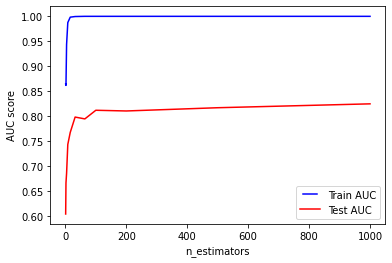

In [24]:
print("Starting timer")
start = time.perf_counter()

n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200, 500, 1000]
n_estimators_train_results = []
n_estimators_test_results = []
for estimator in n_estimators:
   rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
   rf.fit(x_train, y_train)
   train_pred = rf.predict(x_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   n_estimators_train_results.append(roc_auc)
   y_pred = rf.predict(x_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   n_estimators_test_results.append(roc_auc)

   print(f"N-estimators: {estimator} completed at {time.perf_counter() - start:0.4f} seconds")

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, n_estimators_train_results, 'blue', label="Train AUC")
line2, = plt.plot(n_estimators, n_estimators_test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

In [25]:
for i, test_result in enumerate(n_estimators_test_results):
  print(f"{n_estimators[i]}: {test_result}")

1: 0.6043950921160588
2: 0.6665734317893638
4: 0.6857145520996495
8: 0.743669351831133
16: 0.7676680092488999
32: 0.7984168717833967
64: 0.7947434176176624
100: 0.81201984038189
200: 0.8106119937346163
500: 0.8171011411948981
1000: 0.8248676064742299


Starting timer
Max Depth: 1.0 completed at 2.2414 seconds
Max Depth: 2.0 completed at 5.8490 seconds
Max Depth: 3.0 completed at 11.0645 seconds
Max Depth: 4.0 completed at 17.5813 seconds
Max Depth: 5.0 completed at 25.3963 seconds
Max Depth: 6.0 completed at 34.7235 seconds
Max Depth: 7.0 completed at 45.3552 seconds
Max Depth: 8.0 completed at 56.9935 seconds
Max Depth: 9.0 completed at 69.5339 seconds
Max Depth: 10.0 completed at 82.7701 seconds
Max Depth: 11.0 completed at 96.5094 seconds
Max Depth: 12.0 completed at 110.7443 seconds
Max Depth: 13.0 completed at 125.0769 seconds
Max Depth: 14.0 completed at 140.0125 seconds
Max Depth: 15.0 completed at 154.9619 seconds
Max Depth: 16.0 completed at 169.9050 seconds
Max Depth: 17.0 completed at 185.3585 seconds
Max Depth: 18.0 completed at 200.5929 seconds
Max Depth: 19.0 completed at 215.9328 seconds
Max Depth: 20.0 completed at 231.3830 seconds
Max Depth: 21.0 completed at 246.9287 seconds
Max Depth: 22.0 completed at 262.2874 sec

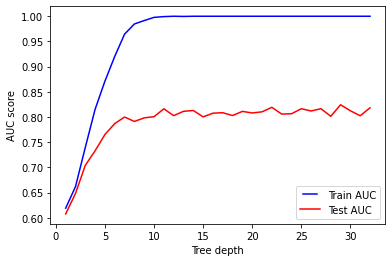

In [26]:
print("Starting timer")
start = time.perf_counter()

max_depths = np.linspace(1, 32, 32, endpoint=True)
max_depth_train_results = []
max_depth_test_results = []

for max_depth in max_depths:
   rf = RandomForestClassifier(max_depth=max_depth, n_jobs=-1)
   rf.fit(x_train, y_train)
   train_pred = rf.predict(x_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   max_depth_train_results.append(roc_auc)
   y_pred = rf.predict(x_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   max_depth_test_results.append(roc_auc)
   print(f"Max Depth: {max_depth} completed at {time.perf_counter() - start:0.4f} seconds")

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, max_depth_train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depths, max_depth_test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

In [27]:
for i, test_result in enumerate(max_depth_test_results):
  print(f"{max_depths[i]}: Train AUC {max_depth_train_results[i]}, TEST AUC: {test_result}")

1.0: Train AUC 0.6189057660112378, TEST AUC: 0.6075371074811665
2.0: Train AUC 0.6616035299619757, TEST AUC: 0.6480383381815469
3.0: Train AUC 0.7396483593945924, TEST AUC: 0.7040165585142091
4.0: Train AUC 0.8153852931806937, TEST AUC: 0.7329193704781085
5.0: Train AUC 0.8711543545009048, TEST AUC: 0.7652625494144849
6.0: Train AUC 0.9203182930383564, TEST AUC: 0.7869210114119489
7.0: Train AUC 0.9645105973416837, TEST AUC: 0.7998993063325128
8.0: Train AUC 0.9846445298467503, TEST AUC: 0.7911165808905796
9.0: Train AUC 0.9914326575706434, TEST AUC: 0.798258372491982
10.0: Train AUC 0.9977564949809201, TEST AUC: 0.8005519504736333
11.0: Train AUC 0.9992747581962491, TEST AUC: 0.8162154098605207
12.0: Train AUC 1.0, TEST AUC: 0.8026124412620272
13.0: Train AUC 0.999603489294211, TEST AUC: 0.8112646378757365
14.0: Train AUC 1.0, TEST AUC: 0.8129055717162676
15.0: Train AUC 1.0, TEST AUC: 0.8001883344521519
16.0: Train AUC 1.0, TEST AUC: 0.8075632132468114
17.0: Train AUC 1.0, TEST AUC: 

Starting timer
----------- Training Set Report -----------
Accuracy 1.0
Precision 1.0
Recall 1.0
F1 1.0
AUC 1.0
Confusion matrix [[1261    0]
 [   0 1521]]


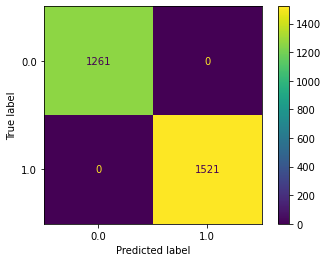

----------- Testing Set Report -----------
Accuracy 0.8200431034482759
Precision 0.8048780487804879
Recall 0.8719512195121951
F1 0.8370731707317074
AUC 0.816709554710226
Confusion matrix [[332 104]
 [ 63 429]]


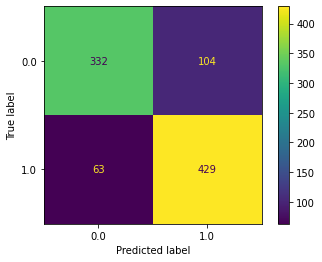

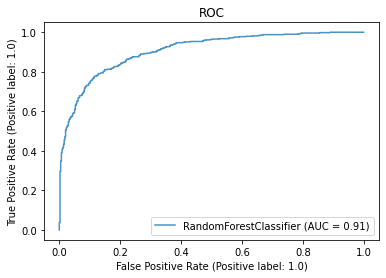

Ran in 67.4954 seconds


In [28]:
print("Starting timer")
start = time.perf_counter()

# Full score report
rfc = RandomForestClassifier(criterion='entropy', max_features='auto', n_estimators=200, max_depth=11)
rfc.fit(x_train, y_train)
y_train_pred = rfc.predict(x_train)
y_test_pred = rfc.predict(x_test)
score_report(rfc.classes_, y_train_pred, y_train, y_test_pred, y_test)
generate_roc(rfc, x_test, y_test)

print(f"Ran in {time.perf_counter() - start:0.4f} seconds")

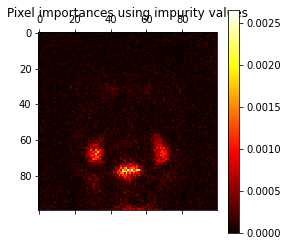

In [29]:
# Feature importance
img_shape = (IMAGE_RESCALE_SIZE, IMAGE_RESCALE_SIZE)

importances = rfc.feature_importances_
imp_reshaped = importances.reshape(img_shape)
plt.matshow(imp_reshaped, cmap=plt.cm.hot)
plt.title("Pixel importances using impurity values")
plt.colorbar()
plt.show()

SVC MODEL

In [22]:
print("Starting timer")
start = time.perf_counter()

original_source_dir = '/content/data/genki4k/files/original'
cropped_dir = '/content/data/genki4k/files/cropped_faces1'
labels_dir = '/content/data/genki4k/labels.txt'

IMAGE_RESCALE_SIZE = 100

# read in the face data
face_data, labels = flatten_data(cropped_dir, labels_dir, IMAGE_RESCALE_SIZE, IMAGE_RESCALE_SIZE)
print(f"Processed data ran in {time.perf_counter() - start:0.4f} seconds")

# # train-test split
x_train, y_train, x_test, y_test = train_test_split(face_data, labels)
print(f"Train test split ran in {time.perf_counter() - start:0.4f} seconds")

# initialize support vector classifer model
svc = SVC(kernel='rbf', probability=False, C=10)

Starting timer
(4000, 100, 100)
(3710, 100, 100)
Processed data ran in 2.6704 seconds
Train test split ran in 2.7082 seconds


In [31]:
print("Starting timer")
start = time.perf_counter()
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}

svc_best_params = perform_gridsearch(svc, parameters, x_train, y_train)
print(f"SVC grid search cross validation ran in {time.perf_counter() - start:0.4f} seconds")
print(svc_best_params)

Starting timer
SVC grid search cross validation ran in 854.4696 seconds
{'C': 10, 'kernel': 'rbf'}


In [25]:
mean_acc_test, mean_prec_test, mean_rec_test, mean_f1_test, mean_auc_test = k_fold_cross_val(svc, face_data, labels, 10)
print('--------- Support Vector Classifier ----------')
print("Mean test accuracy:", mean_acc_test)
print("Mean test precision:", mean_prec_test)
print("Mean test recall:", mean_rec_test)
print("Mean test f1:", mean_f1_test)
print("Mean test AUC:", mean_auc_test)
print('\n')

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


--------- Support Vector Classifier ----------
Mean test accuracy: 0.8107816711590298
Mean test precision: 0.824234474633428
Mean test recall: 0.8274857540270792
Mean test f1: 0.8253450981611312
Mean test AUC: 0.8922840601334701




----------- Training Set Report -----------
Accuracy 0.9949676491732566
Precision 0.9973154362416108
Recall 0.9933155080213903
F1 0.9953114534494307
AUC 0.9951025440573514
Confusion matrix [[1282    4]
 [  10 1486]]


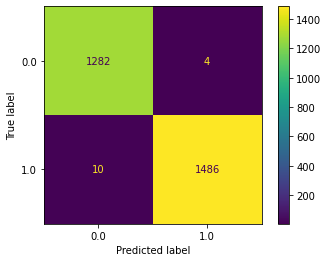

----------- Testing Set Report -----------
Accuracy 0.8178879310344828
Precision 0.8320610687022901
Recall 0.8433268858800773
F1 0.8376560999039384
AUC 0.8146074818694791
Confusion matrix [[323  88]
 [ 81 436]]


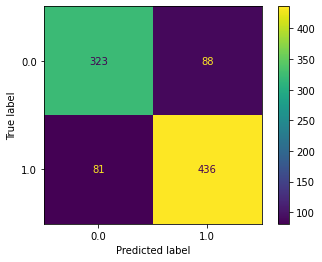

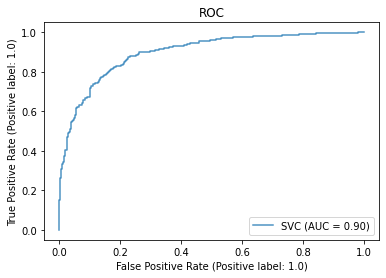

In [24]:
# Score report
svc.fit(x_train, y_train)
y_train_pred = svc.predict(x_train)
y_test_pred = svc.predict(x_test)
score_report(svc.classes_, y_train_pred, y_train, y_test_pred, y_test)
generate_roc(svc, x_test, y_test)

MLP (MultiLayerPerceptron) Classifier

In [35]:
print("Starting timer")
start = time.perf_counter()
original_source_dir = '/content/data/genki4k/files/original'
cropped_dir = '/content/data/genki4k/files/cropped_faces1'
labels_dir = '/content/data/genki4k/labels.txt'

IMAGE_RESCALE_SIZE = 100

face_data, labels = flatten_data(cropped_dir, labels_dir, IMAGE_RESCALE_SIZE, IMAGE_RESCALE_SIZE)
print(f"Processed data ran in {time.perf_counter() - start:0.4f} seconds")

# # train-test split
x_train, y_train, x_test, y_test = train_test_split(face_data, labels)
print(f"Train test split ran in {time.perf_counter() - start:0.4f} seconds")

mlp_parameters = {
    'hidden_layer_sizes': [(10,30,10),(20,20,20)],
    'solver': ['sgd', 'adam'],
    'alpha': [1e-5, 0.0001, 0.001],
}
mlp_best_params = perform_gridsearch(MLPClassifier(), mlp_parameters, x_train, y_train)
print(f"MLP Classifier grid search cross validation ran in {time.perf_counter() - start:0.4f} seconds")
print(mlp_best_params)

Starting timer
(4000, 100, 100)
(3710, 100, 100)
Processed data ran in 4.4762 seconds
Train test split ran in 4.5177 seconds


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


MLP Classifier grid search cross validation ran in 416.6903 seconds
{'alpha': 0.0001, 'hidden_layer_sizes': (20, 20, 20), 'solver': 'adam'}


In [36]:
mlp = MLPClassifier(solver='adam', alpha=0.001, hidden_layer_sizes=(20, 20, 20))
mean_acc_test, mean_prec_test, mean_rec_test, mean_f1_test, mean_auc_test = k_fold_cross_val(mlp, face_data, labels, 5)
print('-------- MLP Classifier -------')
print("Mean test accuracy:", mean_acc_test)
print("Mean test precision:", mean_prec_test)
print("Mean test recall:", mean_rec_test)
print("Mean test f1:", mean_f1_test)
print("Mean test AUC:", mean_auc_test)
print('\n')

-------- MLP Classifier -------
Mean test accuracy: 0.7409703504043128
Mean test precision: 0.7484961055935326
Mean test recall: 0.8315734787411317
Mean test f1: 0.7745625129361693
Mean test AUC: 0.851499437791792




----------- Training Set Report -----------
Accuracy 0.8544212796549245
Precision 0.863837872070931
Recall 0.8777348777348777
F1 0.870730928822215
AUC 0.851326722255061
Confusion matrix [[1013  215]
 [ 190 1364]]


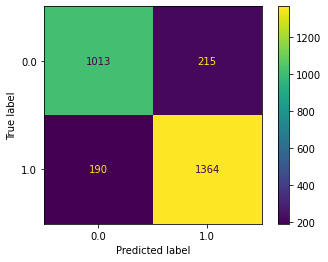

----------- Testing Set Report -----------
Accuracy 0.7952586206896551
Precision 0.7717171717171717
Recall 0.8322440087145969
F1 0.8008385744234799
AUC 0.7956529212016481
Confusion matrix [[356 113]
 [ 77 382]]


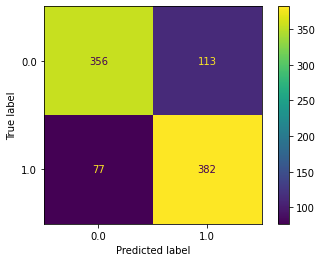

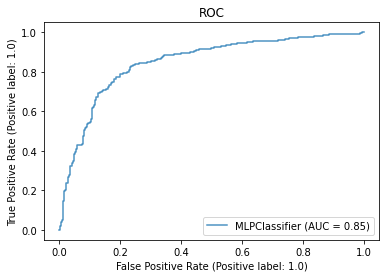

[0. 1.]


In [37]:
mlp = MLPClassifier(solver='adam', alpha=0.001, hidden_layer_sizes=(20, 20, 20))
mlp.fit(x_train, y_train)
y_train_pred = mlp.predict(x_train)
y_test_pred = mlp.predict(x_test)
score_report(mlp.classes_, y_train_pred, y_train, y_test_pred, y_test)
generate_roc(mlp, x_test, y_test)
print(mlp.classes_)

Convolutional Neural Networks

Starting timer
(3710, 32, 32, 3)
(3710,)
Processed data ran in 2.3882 seconds
Train test split ran in 2.4042 seconds
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 15, 15, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
   

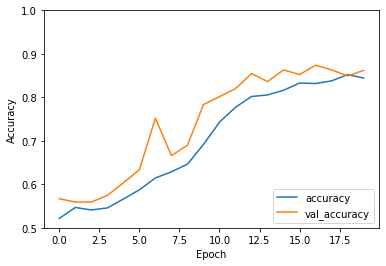

29/29 - 0s - loss: 0.3257 - accuracy: 0.8621 - 398ms/epoch - 14ms/step
Loss on test set - BASIC CNN  0.3257095515727997
Test accuracy - BASIC CNN  0.8620689511299133
----------- Training Set Report -----------
Accuracy 0.8856937455068297
Precision 0.8912326961107448
Recall 0.8983388704318936
F1 0.8947716743878225
AUC 0.8845648933208802
Confusion matrix [[1112  165]
 [ 153 1352]]


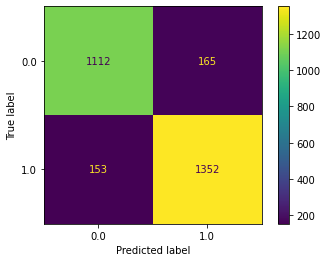

----------- Testing Set Report -----------
Accuracy 0.8620689655172413
Precision 0.87109375
Recall 0.8779527559055118
F1 0.8745098039215686
AUC 0.8604049493813273
Confusion matrix [[354  66]
 [ 62 446]]


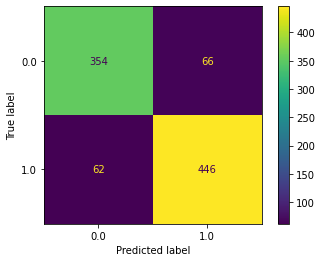

In [49]:
# Basic CNN Model
print("Starting timer")
start = time.perf_counter()

original_source_dir = '/content/data/genki4k/files/original'
source_dir = '/content/data/genki4k/files/cropped_faces1'
cropped_dir = '/content/data/genki4k/files/cropped_faces1'
labels_dir = '/content/data/genki4k/labels.txt'

# read in the face data
face_data, labels = process_data(cropped_dir, labels_dir, 32)
print(f"Processed data ran in {time.perf_counter() - start:0.4f} seconds")

# # train-test split
x_train, y_train, x_test, y_test = train_test_split(face_data, labels)
print(f"Train test split ran in {time.perf_counter() - start:0.4f} seconds")

basic_CNN_model = build_CNN_basic()
basic_CNN_model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=['accuracy'])
hist = basic_CNN_model.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test))

plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()
test_loss, test_acc = basic_CNN_model.evaluate(x_test, y_test, verbose=2)
print("Loss on test set - BASIC CNN ", test_loss)
print('Test accuracy - BASIC CNN ', test_acc)
y_train_pred = predict_label(basic_CNN_model.predict(x_train))
y_test_pred = predict_label(basic_CNN_model.predict(x_test))
# REPLACE CLASSES HERE 
score_report([0., 1.], y_train_pred, y_train, y_test_pred, y_test)

Starting timer
(3710, 32, 32, 1)
(3710,)
Processed data ran in 4.0533 seconds
Train test split ran in 4.0599 seconds
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 32, 32, 20)        520       
                                                                 
 elu_9 (ELU)                 (None, 32, 32, 20)        0         
                                                                 
 batch_normalization_9 (Batc  (None, 32, 32, 20)       80        
 hNormalization)                                                 
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 16, 16, 20)       0         
 g2D)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 16, 16, 20)        0         
   

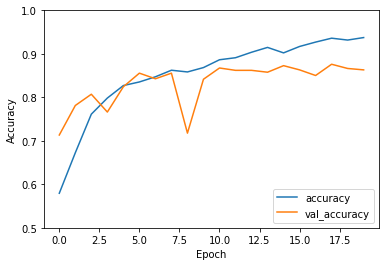

29/29 - 1s - loss: 0.5267 - accuracy: 0.8631 - 873ms/epoch - 30ms/step
Loss on test set - LENET CNN  0.5267031192779541
Test accuracy - LENET CNN  0.8631465435028076
----------- Training Set Report -----------
Accuracy 0.9805895039539899
Precision 0.9959239130434783
Recall 0.9682959048877147
F1 0.9819156061620897
AUC 0.9817820218444884
Confusion matrix [[1262    6]
 [  48 1466]]


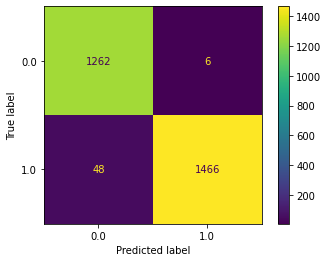

----------- Testing Set Report -----------
Accuracy 0.8631465517241379
Precision 0.918918918918919
Recall 0.8176352705410822
F1 0.865323435843054
AUC 0.8668595933124991
Confusion matrix [[393  36]
 [ 91 408]]


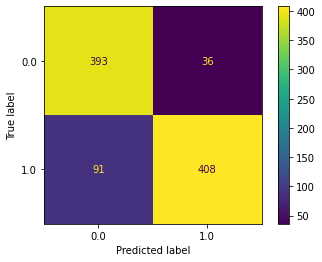

In [58]:
# LeNet CNN Model
print("Starting timer")
start = time.perf_counter()

original_source_dir = '/content/data/genki4k/files/original'
source_dir = '/content/data/genki4k/files/cropped_faces1'
cropped_dir = '/content/data/genki4k/files/cropped_faces1'
labels_dir = '/content/data/genki4k/labels.txt'

### DATA ###

# read in the face data
face_data, labels = process_data(cropped_dir, labels_dir, 32, grey_scale=True)
print(f"Processed data ran in {time.perf_counter() - start:0.4f} seconds")

# # train-test split
x_train, y_train, x_test, y_test = train_test_split(face_data, labels)
print(f"Train test split ran in {time.perf_counter() - start:0.4f} seconds")

#LeNet CNN Model
LeNet_CNN_model = build_CNN_LeNet()
LeNet_CNN_model.compile(optimizer='rmsprop', loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=['accuracy'])
hist = LeNet_CNN_model.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test))

plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()
test_loss, test_acc = LeNet_CNN_model.evaluate(x_test, y_test, verbose=2)
print("Loss on test set - LENET CNN ", test_loss)
print('Test accuracy - LENET CNN ', test_acc)
y_train_pred = predict_label(LeNet_CNN_model.predict(x_train))
y_test_pred = predict_label(LeNet_CNN_model.predict(x_test))
# REPLACE CLASSES HERE 
score_report([0., 1.], y_train_pred, y_train, y_test_pred, y_test)

Starting timer
(3710, 227, 227, 3)
(3710,)
Processed data ran in 4.5800 seconds
Train test split ran in 5.0482 seconds
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 55, 55, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 27, 27, 256)      1024      
 hN

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
87/87 [==============================] - 393s 5s/step - loss: 1.0218 - accuracy: 0.5963 - val_loss: 0.7228 - val_accuracy: 0.5884
Epoch 2/20
87/87 [==============================] - 389s 4s/step - loss: 0.8640 - accuracy: 0.6488 - val_loss: 0.6120 - val_accuracy: 0.6595
Epoch 3/20
87/87 [==============================] - 395s 5s/step - loss: 0.8122 - accuracy: 0.6675 - val_loss: 0.5912 - val_accuracy: 0.7155
Epoch 4/20
87/87 [==============================] - 394s 5s/step - loss: 0.6506 - accuracy: 0.7142 - val_loss: 0.5491 - val_accuracy: 0.7198
Epoch 5/20
87/87 [==============================] - 384s 4s/step - loss: 0.5968 - accuracy: 0.7365 - val_loss: 0.5082 - val_accuracy: 0.7672
Epoch 6/20
87/87 [==============================] - 394s 5s/step - loss: 0.5627 - accuracy: 0.7624 - val_loss: 0.4818 - val_accuracy: 0.7769
Epoch 7/20
87/87 [==============================] - 392s 5s/step - loss: 0.4695 - accuracy: 0.7958 - val_loss: 0.5695 - val_accuracy: 0.7284
Epoch 8/20
87

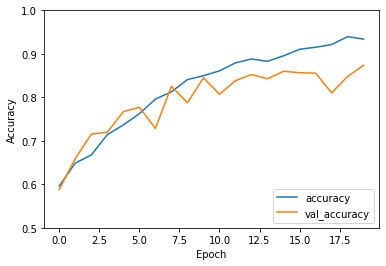

29/29 - 29s - loss: 0.3068 - accuracy: 0.8739 - 29s/epoch - 1s/step
Loss on test set - ALEXNET CNN  0.30684447288513184
Test accuracy - ALEXNET CNN  0.8739224076271057
----------- Training Set Report -----------
Accuracy 0.9820273184759166
Precision 0.9732201175702155
Recall 0.9939959973315544
F1 0.9834983498349835
AUC 0.981019822516128
Confusion matrix [[1242   41]
 [   9 1490]]


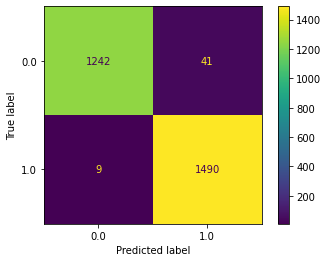

----------- Testing Set Report -----------
Accuracy 0.8739224137931034
Precision 0.878095238095238
Recall 0.896887159533074
F1 0.8873917228103946
AUC 0.8711488937761986
Confusion matrix [[350  64]
 [ 53 461]]


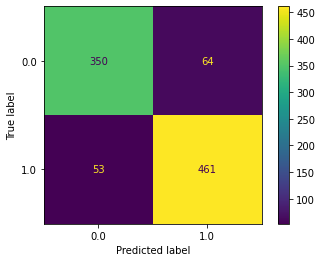

In [25]:
# AlexNet CNN Model
print("Starting timer")
start = time.perf_counter()

original_source_dir = '/content/data/genki4k/files/original'
source_dir = '/content/data/genki4k/files/cropped_faces1'
cropped_dir = '/content/data/genki4k/files/cropped_faces1'
labels_dir = '/content/data/genki4k/labels.txt'

# read in the face data
face_data, labels = process_data(cropped_dir, labels_dir, 227)
print(f"Processed data ran in {time.perf_counter() - start:0.4f} seconds")

# # train-test split
x_train, y_train, x_test, y_test = train_test_split(face_data, labels)
print(f"Train test split ran in {time.perf_counter() - start:0.4f} seconds")

AlexNet_CNN_model = build_CNN_AlexNet()
AlexNet_CNN_model.compile(optimizer=tf.optimizers.SGD(lr=0.001), loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=['accuracy'])
hist = AlexNet_CNN_model.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test))

plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()
test_loss, test_acc = AlexNet_CNN_model.evaluate(x_test, y_test, verbose=2)
print("Loss on test set - ALEXNET CNN ", test_loss)
print('Test accuracy - ALEXNET CNN ', test_acc)
y_train_pred = predict_label(AlexNet_CNN_model.predict(x_train))
y_test_pred = predict_label(AlexNet_CNN_model.predict(x_test))
# REPLACE CLASSES HERE 
score_report([0., 1.], y_train_pred, y_train, y_test_pred, y_test)